ChEn-3170: Computational Methods in Chemical Engineering Spring 2020 UMass Lowell; Prof. V. F. de Almeida **20Jan2018**

# 07a. Computational Stoichiometry
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \DeclareMathOperator{\rank}{rank}
$

---
## Table of Contents<a id="toc">
* [Introduction](#intro)
* [Stoichiometric Matrix](#stoicmtrx)
* [Linear Independent Reactions](#indepen)
* [Principal Reaction Sub-Mechanisms](#subreact)
---

## Introduction<a id="intro"></a>
Refer to Notebook 7.

## [Stoichiometric matrix](#toc)<a id="stoicmtrx"></a>
After reading a reaction mechanism from file, and storing the input data into data types, construct the stoichiometric coefficient matrix, $\Smtrx$.

In [3]:
'''Read and process a NOx decomposition reaction mechanism'''
try:
    from chen_3170.toolkit import reaction_mechanism
except ModuleNotFoundError:
    assert False, 'You need to provide your own reaction_mechanism function here. Bailing out.'

(species, reactions, s_mtrx, _, _) = reaction_mechanism('data/nox-rxn.txt')

r0 :  2 N2O5       <=> 2 N2O4 + O2
r1 :  N2O5       <=>   NO2 + NO3
r2 :  NO2 + NO3  <=>   N2O5
r3 :  NO3        <=>   O2 + NO
r4 :  NO + N2O5  <=> 3 NO2
r5 :  2 NO2        <=>   N2O4
n_reactions = 6
['O2', 'NO3', 'NO', 'N2O4', 'N2O5', 'NO2']
# species = 6

s_mtrx =
 [[ 1.  0.  0.  2. -2.  0.]
 [ 0.  1.  0.  0. -1.  1.]
 [ 0. -1.  0.  0.  1. -1.]
 [ 1. -1.  1.  0.  0.  0.]
 [ 0.  0. -1.  0. -1.  3.]
 [ 0.  0.  0.  1.  0. -2.]]
m x n = (6, 6)
matrix shape = (6, 6)


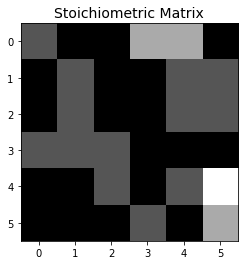

In [4]:
'''Summary'''

from chen_3170.help import print_reactions

print_reactions(reactions)

print(species)  
print('# species =',len(species))
print('')
print('s_mtrx =\n',s_mtrx)
print('m x n =',s_mtrx.shape)

from chen_3170.help import plot_matrix

import numpy as np
np.set_printoptions(precision=3, threshold=300, edgeitems=8, linewidth=100)

plot_matrix(s_mtrx, title='Stoichiometric Matrix')

## [Linearly independent reactions](#toc)<a id="indepen"></a>
The stoichiometric matrix represents a linear system of equations in two different instances. 
+ First, a mass balance set of equations for the chemical reactions when the molar masses of the species involved are used as a vector. The product of the stoichiometric matrix and this vector must result in the zero vector, *i.e.* $\Smtrx\,\mvec = \zerovec$. 
+ Second, the reaction rates are related to the species production rates in a similar way, *i.e.*, $\Smtrx^\top\,\rvec = \gvec$. In both cases the system of equations lead to a rectangular system. Here we compute the rank of the stoichiometric matrix to discover how many of the reactions are linearly independent.

## [Principal Reaction Sub-Mechanisms](#toc)<a id="subreact"></a>
Here we form all possible combination of full-rank reaction sub-mechanisms.

# reactions =  6
# species   =  6
rank of S =  4
# of all possible sub_mechanisms = 15
# of full-rank sub_mechanisms = 9


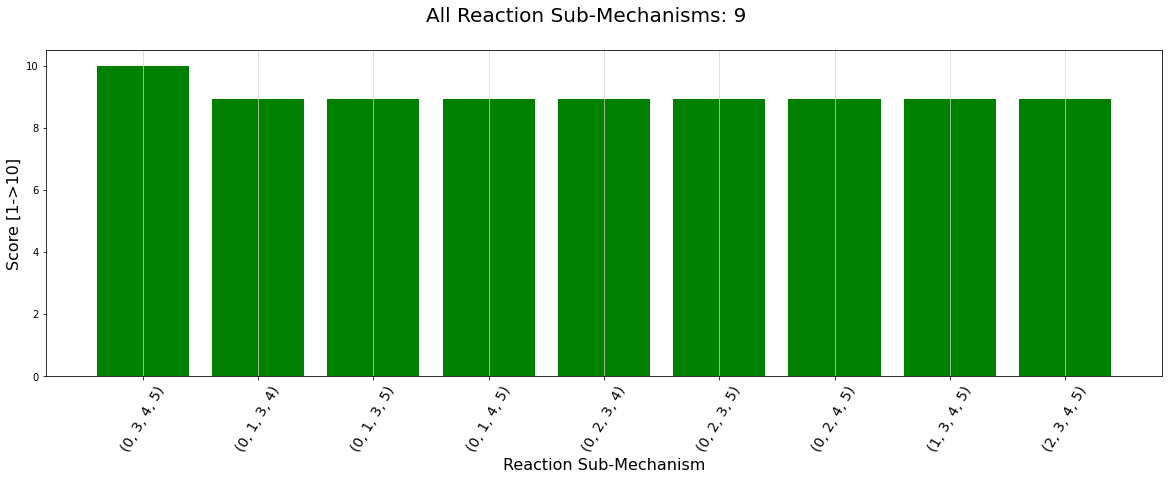

r0 :  2 N2O5       <=> 2 N2O4 + O2
r1 :  N2O5       <=>   NO2 + NO3
r2 :  NO2 + NO3  <=>   N2O5
r3 :  NO3        <=>   O2 + NO
r4 :  NO + N2O5  <=> 3 NO2
r5 :  2 NO2        <=>   N2O4
n_reactions = 6

Reaction Sub Mechanism: 0 (score 10.00)
r0 2 N2O5       <=> 2 N2O4 + O2
r3 NO3        <=>   O2 + NO
r4 NO + N2O5  <=> 3 NO2
r5 2 NO2        <=>   N2O4


In [5]:
'''2.4 Most relevant reaction sub-mechanisms'''
try:
    from chen_3170.toolkit import sub_mechanisms
    from chen_3170.toolkit import plot_reaction_sub_mechanisms
except ModuleNotFoundError:
    assert False, 'You need to provide your own reaction_mechanism function here. Bailing out.'

sub_mech = sub_mechanisms(species, reactions, s_mtrx)

plot_reaction_sub_mechanisms(sub_mech, mode='all')

print_reactions(reactions)
print('')

from chen_3170.help import print_reaction_sub_mechanisms

print_reaction_sub_mechanisms(sub_mech, mode='top')